In [48]:
import collections
import math

import numpy as np
import os
import tensorflow as tf
from tensorflow import keras
import tensorflow_federated as tff
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split


from keras.models import Sequential 
from keras.layers import Dense
from keras.initializers import GlorotUniform
from keras.initializers import HeUniform
from keras.layers import Dense, Dropout


TEST_SIZE = 0.2
NUM_CLIENTS = 10
ACTIVE_CLIENTS = 500
BATCH_SIZE = 512
DROPOUT = 0.1
EPOCHS = 10
PREFETCH_BUFFER = 10
NUM_ROUNDS = 5
AGG_ALGO = "weighted prox"
UNBALANCED = True

np.random.seed(42)

In [55]:
# Import del dataset e divisione in train e test
train_df = pd.read_csv('datasets/train_titanic.csv')
test_df = pd.read_csv('datasets/test_titanic.csv')

test_x = test_df.drop(columns=['Transported'])
test_y = test_df['Transported']

# Funzione per il preprocessing dei dati del singolo client che divide il dataset in batch
def preprocess(dataset):
  return dataset.repeat(EPOCHS).batch(BATCH_SIZE).prefetch(PREFETCH_BUFFER)

def client_distribution(dataset, part):
    positive = []
    negative = []

    dataset_0 = dataset[dataset['Transported'] == 0]
    dataset_1 = dataset[dataset['Transported'] == 1]
    print(len(dataset_0), len(dataset_1))

    while len(positive) < len(dataset_1) and len(negative) < len(dataset_0):
        for c in range(round(NUM_CLIENTS/2)):
            positive.extend([c]*part)
            negative.extend([c]*(4-part))
        for c in range(round(NUM_CLIENTS/2), NUM_CLIENTS):
            positive.extend([c]*(4-part))
            negative.extend([c]*part)
    print(len(negative), len(positive))

    if len(dataset_1) < len(positive):
        positive = positive[:len(dataset_1)]
    else:
        dataset_1 = dataset_1.iloc[:len(positive),:]
    
    if len(dataset_0) < len(negative):
        negative = negative[:len(dataset_0)]
    else:
        dataset_0 = dataset_0.iloc[:len(negative),:]

    dataset_1['client_num'] = positive
    dataset_0['client_num'] = negative
    ret = pd.concat([dataset_1, dataset_0])
    print(ret.shape)

    return ret

# funzione per aggiungere una colonna client_num al dataset in modo tale che ogni client abbia una percentuale di 
# righe del dataset diversa indipendente dalla label. La percentuale è generata a caso, ma la somma deve fare il 100% del dataset
def client_unbalanced(dataset):
    client_num = []
    prob = np.random.pareto(1, NUM_CLIENTS)
    prob /= np.sum(prob)
    print(prob)
    for i in range(len(dataset)):
        client_num.append(np.random.choice(NUM_CLIENTS, p=prob))
    print(len(client_num))
    # stampa numero di volte che compare ogni client in client_num
    print([client_num.count(x) for x in range(NUM_CLIENTS)])
    dataset['client_num'] = client_num
    return dataset


# Funzione per la creazione di un dataset ClientData a partire dal dataset di training a cui viene
# aggiunta una colonna client_nums che assegna ad ogni riga un client randomico
def create_clients(dataset, perc):
    if UNBALANCED: 
        dataset = client_unbalanced(dataset)
    else:
        dataset = client_distribution(dataset, perc)

    # Viene convertito il dataset in dizionari, uno per ogni client, con label e pixel associati
    client_train_dataset = collections.OrderedDict()
    grouped_dataset = dataset.groupby('client_num')
    for key, item in grouped_dataset:
        current_client = grouped_dataset.get_group(key)
        data = collections.OrderedDict((('y',current_client.iloc[:,-2]), ('x', current_client.iloc[:,:-2])))
        client_train_dataset[key] = data

    # I dizionari vengono convertiti in ClientDataset
    def serializable_dataset_fn(client_id):
        client_data = client_train_dataset[client_id]
        return tf.data.Dataset.from_tensor_slices(client_data)

    tff_train_data = tff.simulation.datasets.ClientData.from_clients_and_tf_fn(
        client_ids=list(client_train_dataset.keys()),
        serializable_dataset_fn=serializable_dataset_fn
    )

    return tff_train_data

# Creazione della lista contenente i client con i relativi dataset
elem_spec = {}
def init():
    client_data_df = create_clients(train_df, 3)
    client_ids = sorted(client_data_df.client_ids)[:ACTIVE_CLIENTS]
    return [preprocess(client_data_df.create_tf_dataset_for_client(x)) for x in client_ids]

In [56]:
def create_keras_model():
  model = Sequential()

  model.add(Dense(test_x.shape[-1], kernel_initializer = HeUniform(), activation = 'relu', input_dim = test_x.shape[-1]))
  model.add(Dropout(DROPOUT))
  model.add(Dense(1024, kernel_initializer = HeUniform(), activation = 'relu', kernel_regularizer = tf.keras.regularizers.l2(30e-6)))
  model.add(Dropout(DROPOUT))
  model.add(Dense(256, kernel_initializer = HeUniform(), activation = 'relu', kernel_regularizer = tf.keras.regularizers.l2(30e-6)))
  model.add(Dropout(DROPOUT))
  model.add(Dense(128, kernel_initializer = HeUniform(), activation = 'relu', kernel_regularizer = tf.keras.regularizers.l2(30e-6)))
  model.add(Dropout(DROPOUT))
  model.add(Dense(1, kernel_initializer = GlorotUniform(), activation = 'sigmoid'))
  return model

In [57]:
def model_fn():
  # We _must_ create a new model here, and _not_ capture it from an external
  # scope. TFF will call this within different graph contexts.
  keras_model = create_keras_model()
  return tff.learning.models.from_keras_model(
      keras_model,
      input_spec=elem_spec,
      loss=tf.keras.losses.BinaryFocalCrossentropy(),
      metrics=[tf.keras.metrics.BinaryAccuracy()])

In [58]:
def aggregator(algo):
    if algo == 'weighted avg':
        training_process = tff.learning.algorithms.build_weighted_fed_avg(model_fn, 
                                                                          client_optimizer_fn=tff.learning.optimizers.build_adam(learning_rate=0.0001),
                                                                          server_optimizer_fn=tff.learning.optimizers.build_adam(learning_rate=0.0001))

    if algo == 'unweighted avg':
        training_process = tff.learning.algorithms.build_unweighted_fed_avg(model_fn, 
                                                                            client_optimizer_fn=tff.learning.optimizers.build_adam(learning_rate=0.0001),
                                                                            server_optimizer_fn=tff.learning.optimizers.build_adam(learning_rate=0.0001))

    if algo == 'weighted prox':
        training_process = tff.learning.algorithms.build_weighted_fed_prox(model_fn, 
                                                                           proximal_strength=20.0, 
                                                                           client_optimizer_fn=tff.learning.optimizers.build_adam(learning_rate=0.0001),
                                                                           server_optimizer_fn=tff.learning.optimizers.build_adam(learning_rate=0.0001))
    if algo == 'unweighted prox':
        training_process = tff.learning.algorithms.build_weighted_fed_prox(model_fn, 
                                                                           proximal_strength=20.0,
                                                                           client_optimizer_fn=tff.learning.optimizers.build_adam(learning_rate=0.0001),
                                                                           server_optimizer_fn=tff.learning.optimizers.build_adam(learning_rate=0.0001))
    return training_process


In [59]:
federated_train_data = init()
elem_spec = federated_train_data[0].element_spec
training_process = aggregator(AGG_ALGO)

#train
for round_num in range(NUM_ROUNDS):
  result = training_process.next(train_state, federated_train_data)
  train_state = result.state
  train_metrics = result.metrics
  print('round {:2d}, metrics={}'.format(round_num, train_metrics))

#evaluation
def keras_evaluate(state):
  # Take our global model weights and push them back into a Keras model to
  # use its standard `.evaluate()` method.
  keras_model = create_keras_model()
  keras_model.compile(
      loss=tf.keras.losses.BinaryFocalCrossentropy(),
      metrics=[tf.keras.metrics.BinaryAccuracy()])
  model_weights = training_process.get_model_weights(state)
  model_weights.assign_weights_to(keras_model)
  loss, accuracy = keras_model.evaluate(x=test_x, y=test_y)
  print('\tEval: loss={l:.3f}, accuracy={a:.3f}'.format(l=loss, a=accuracy))
print(type(train_state))

keras_evaluate(train_state)

[0.04051642 0.02432298 0.28718827 0.26859541 0.00104519 0.07151917
 0.02666109 0.03259379 0.22698705 0.02057063]
5563
[235, 140, 1615, 1483, 4, 384, 134, 148, 1288, 132]


2024-09-23 16:21:07.513289: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-23 16:21:07.513427: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2024-09-23 16:21:07.513494: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2024-09-23 16:21:07.513776: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-23 16:21:07.513873: W tensorflow/core/common_runtime/gpu/gpu_d

round  0, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('binary_accuracy', 0.6163221), ('loss', 0.22618158), ('num_examples', 55630), ('num_batches', 113)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', OrderedDict([('update_non_finite', 0)]))])
round  1, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('binary_accuracy', 0.60683084), ('loss', 0.24243155), ('num_examples', 55630), ('num_batches', 113)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', OrderedDict([('update_non_finite', 0)]))])
round  2, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('binary_accuracy', 0.61909044), ('loss', 0.22945909), ('num_examples', 55630), ('num_batches', 113)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', OrderedDict([('update

KeyboardInterrupt: 

Esperimenti
==============
Il primo set di esperimenti riguarda la strategia di aggregazione dei pesi dei client da parte dei server. Sono state valutate 4 strategie, due sulla media dei pesi (pesata e non pesata sul numero di elementi del set per client) e due con l'algoritmo di prossimità che esegue l'aggregazione dei pesi come per la media, ma con un parametro aggiuntivo che aggiunge un termine di regolarizzazione per evitare che i pesi si allontanino troppo dai pesi del server.

In [ ]:
# Tuning del parametro di proximal strength
def tune_proximal_strength():
    prox_list = []
    for i in [1.0, 10.0, 20.0, 128.0, 256.0, 512.0]:
        training_process = aggregator('weighted prox')
        train_state = training_process.initialize()
        curr = []
        for round_num in range(NUM_ROUNDS):
            result = training_process.next(train_state, federated_train_data)
            train_state = result.state
            train_metrics = result.metrics
            print('round {:2d}, metrics={}'.format(round_num, train_metrics))
            # creare una ltupla con round_num e il valore di accuracy
            acc_tuple = (round_num, train_metrics['client_work']['train']['binary_accuracy'])
            curr.append(acc_tuple)
        # creare una tupla con il valore di proximal strength e la lista di tuple
        prox_list.append((i, curr))

    plt.figure(figsize=(10, 6))

    for prox_strength, acc_list in prox_list:
        rounds = [x[0] for x in acc_list]
        accuracies = [x[1] for x in acc_list]
        plt.plot(rounds, accuracies, label=f'Proximal Strength {prox_strength}')

    plt.xlabel('Round')
    plt.ylabel('Accuracy')
    plt.title('Accuracy per Round for Different Proximal Strengths')
    plt.legend()
    plt.grid(True)
    plt.show()
    plt.savefig('proximal_strength.png')


Viene creato il dataset federato assegnando ad ogni client una riga del dataset con probabilità che segue una distribuzione di pareto in modo da rendere le probabilità più sbilanciate e poter testare l'importanza o meno di considerare la media pesata. Viene fissato il numero di epoche per client per round e round totali rispettivamente a 10 e 5. Anche il numero di client è fissato a 10.

2024-09-23 16:00:39.356360: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-23 16:00:39.356501: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2024-09-23 16:00:39.356569: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2024-09-23 16:00:39.357030: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-23 16:00:39.357134: W tensorflow/core/common_runtime/gpu/gpu_d

round  0, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('binary_accuracy', 0.6435017), ('loss', 0.18427555), ('num_examples', 55630), ('num_batches', 113)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', OrderedDict([('update_non_finite', 0)]))])
round  1, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('binary_accuracy', 0.65338844), ('loss', 0.17605208), ('num_examples', 55630), ('num_batches', 113)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', OrderedDict([('update_non_finite', 0)]))])
round  2, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('binary_accuracy', 0.67032176), ('loss', 0.16700375), ('num_examples', 55630), ('num_batches', 113)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', OrderedDict([('update

2024-09-23 16:00:50.075922: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-23 16:00:50.076057: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2024-09-23 16:00:50.076136: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2024-09-23 16:00:50.076512: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-23 16:00:50.076616: W tensorflow/core/common_runtime/gpu/gpu_d

round  0, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('binary_accuracy', 0.64317816), ('loss', 0.20801254), ('num_examples', 55630), ('num_batches', 113)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_count', ())])), ('finalizer', OrderedDict([('update_non_finite', 0)]))])
round  1, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('binary_accuracy', 0.66048896), ('loss', 0.19075501), ('num_examples', 55630), ('num_batches', 113)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_count', ())])), ('finalizer', OrderedDict([('update_non_finite', 0)]))])
round  2, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('binary_accuracy', 0.67695487), ('loss', 0.17810866), ('num_examples', 55630), ('num_batches', 113)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_count', ())])), ('finalizer', OrderedDict([('update_n

2024-09-23 16:01:00.428801: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-23 16:01:00.428950: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2024-09-23 16:01:00.429021: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2024-09-23 16:01:00.429305: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-23 16:01:00.429406: W tensorflow/core/common_runtime/gpu/gpu_d

round  0, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('binary_accuracy', 0.6495236), ('loss', 0.51236594), ('num_examples', 55630), ('num_batches', 113)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', OrderedDict([('update_non_finite', 0)]))])
round  1, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('binary_accuracy', 0.66223264), ('loss', 0.46845433), ('num_examples', 55630), ('num_batches', 113)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', OrderedDict([('update_non_finite', 0)]))])
round  2, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('binary_accuracy', 0.6778357), ('loss', 0.47654015), ('num_examples', 55630), ('num_batches', 113)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', OrderedDict([('update_

2024-09-23 16:01:11.170054: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-23 16:01:11.170200: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2024-09-23 16:01:11.170269: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2024-09-23 16:01:11.170576: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-23 16:01:11.170690: W tensorflow/core/common_runtime/gpu/gpu_d

round  0, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('binary_accuracy', 0.5260291), ('loss', 0.6060564), ('num_examples', 55630), ('num_batches', 113)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', OrderedDict([('update_non_finite', 0)]))])
round  1, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('binary_accuracy', 0.5323926), ('loss', 0.6020751), ('num_examples', 55630), ('num_batches', 113)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', OrderedDict([('update_non_finite', 0)]))])
round  2, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('binary_accuracy', 0.53512496), ('loss', 0.6048347), ('num_examples', 55630), ('num_batches', 113)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', OrderedDict([('update_non

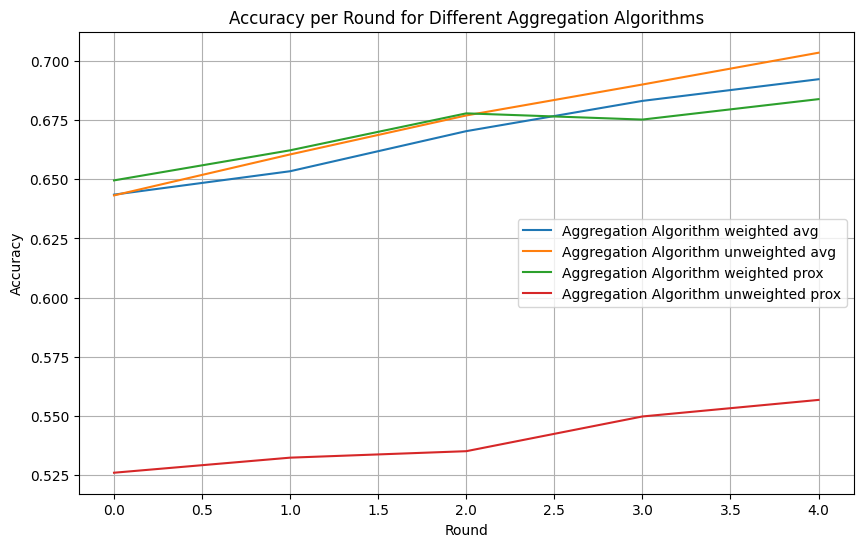

<Figure size 640x480 with 0 Axes>

In [46]:
federated_train_data = init()
elem_spec = federated_train_data[0].element_spec

def agg_experiment():
    prox_list = []
    for i in ['weighted avg', 'unweighted avg', 'weighted prox', 'unweighted prox']:
        training_process = aggregator(i)
        train_state = training_process.initialize()
        curr = []
        for round_num in range(NUM_ROUNDS):
            result = training_process.next(train_state, federated_train_data)
            train_state = result.state
            train_metrics = result.metrics
            print('round {:2d}, metrics={}'.format(round_num, train_metrics))
            # creare una tupla con round_num e il valore di accuracy
            acc_tuple = (round_num, train_metrics['client_work']['train']['binary_accuracy'])
            curr.append(acc_tuple)
        # creare una tupla con il valore di proximal strength e la lista di tuple
        prox_list.append((i, curr))

    plt.figure(figsize=(10, 6))

    for algo, acc_list in prox_list:
        rounds = [x[0] for x in acc_list]
        accuracies = [x[1] for x in acc_list]
        plt.plot(rounds, accuracies, label=f'Aggregation Algorithm {algo}')

    plt.xlabel('Round')
    plt.ylabel('Accuracy')
    plt.title('Accuracy per Round for Different Aggregation Algorithms')
    plt.legend()
    plt.grid(True)
    plt.show()
    plt.savefig('agg_algo.png')
agg_experiment()
